# Visium HD dataset

In [56]:
#! /opt/homebrew/bin/python3 -m pip install scanpy

In [57]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scanorama


## Normalize the spatial dataset

In [58]:

# Had to symlink to image paths into the "spatial" directory within visium_dataset_path
# These are Postnatal Day 7, Wild-type, CD-1 IGS Mice from Charles River

import spatialdata_io as sdio
from spatialdata_io.experimental import to_legacy_anndata

visium_dataset_path = "../Shults_SpatialData/binned_outputs/square_008um"
count_file = "{}/filtered_feature_bc_matrix.h5".format(visium_dataset_path)

In [59]:
# Convert tissue position parquet file into csv so it can be read by scanpy read_visium function

import pandas as pd
df = pd.read_parquet("{}/spatial/tissue_positions.parquet".format(visium_dataset_path))
df.to_csv("{}/spatial/tissue_positions_list.csv".format(visium_dataset_path), index=False)

In [60]:
#vis_adata = sc.read_visium(visium_dataset_path)
vis_sdata = sdio.visium(visium_dataset_path, dataset_id="D1")    # visium_hd function does not work (no inferred dataset id)
# D1 is what I think is the dataset ID based on the vis_adata.uns["spatial"] metadata
vis_sdata

INFO     reading ../Shults_SpatialData/binned_outputs/square_008um/filtered_feature_bc_matrix.h5                   


/opt/homebrew/lib/python3.12/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/homebrew/lib/python3.12/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/homebrew/lib/python3.12/site-packages/spatialdata_io/readers/visium.py:155: DtypeWarning: Columns (1,2,3,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  coords = pd.read_csv(tissue_positions_file, header=None, index_col=0)
/opt/homebrew/lib/python3.12/site-packages/spatialdata/models/models.py:1035: UserWarning: Converting `region_key: region` to categorical dtype.
  return convert_region_column_to_categorical(adata)


SpatialData object
├── Images
│     ├── 'D1_hires_image': DataArray[cyx] (3, 3866, 6000)
│     └── 'D1_lowres_image': DataArray[cyx] (4, 3000, 3200)
├── Shapes
│     └── 'D1': GeoDataFrame shape: (97750, 2) (2D shapes)
└── Tables
      └── 'table': AnnData (97750, 19059)
with coordinate systems:
    ▸ 'downscaled_hires', with elements:
        D1_hires_image (Images), D1 (Shapes)
    ▸ 'downscaled_lowres', with elements:
        D1_lowres_image (Images), D1 (Shapes)
    ▸ 'global', with elements:
        D1 (Shapes)

INFO     Dropping coordinate system 'global' since it doesn't have relevant elements.                              
INFO     Rasterizing image for faster rendering.                                                                   


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.4615763168012303..3.2598385236447522].


INFO     Rasterizing image for faster rendering.                                                                   


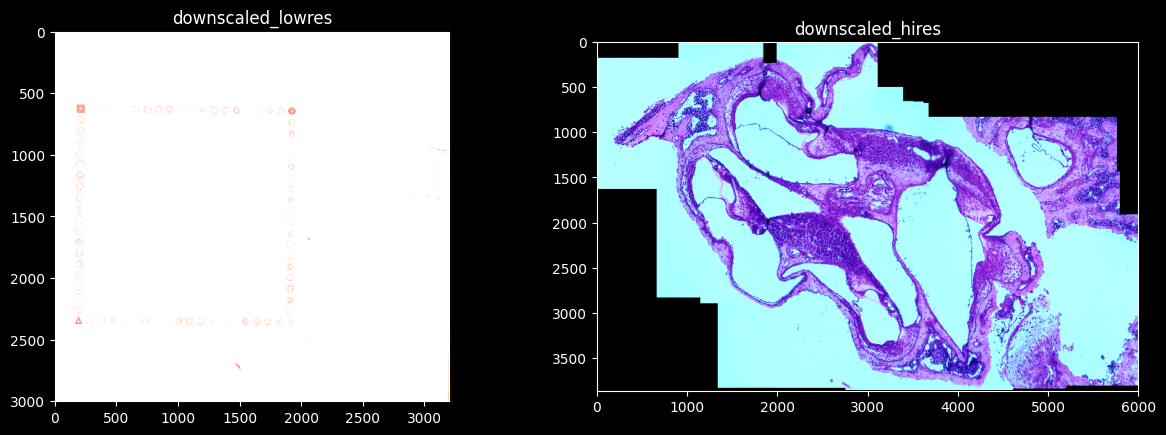

In [61]:
import spatialdata_plot
vis_sdata.pl.render_images().pl.show()



In [62]:
# Bounding box query to only get the hires part of the entire image. This should hopefully yield a better result

from spatialdata import bounding_box_query

img_to_use = "D1_hires_image"
x = len(vis_sdata.images[img_to_use].x)
y = len(vis_sdata.images[img_to_use].y)

vis_sdata = bounding_box_query(vis_sdata,
                           axes=("x", "y"),
                           min_coordinate=[1000, 1000],
                           max_coordinate=[2000, 2000], # think this is the Organ of Corti region, according to Chris.  Need to verify
                           #max_coordinate=[x, y],
                           target_coordinate_system="downscaled_hires",
                           filter_table=True,
                           )

"""
# Alternatively, can pass a DataArray to bounding_box_query but cannot filter table.  Returns a DataArray that can be added to the vis_sdata object
query = bounding_box_query(vis_sdata["D1_hires_image"],
                           axes=("x", "y"),
                           min_coordinate=[0, 0],
                           max_coordinate=[3000, 3000],
                           target_coordinate_system="downscaled_hires",
                           filter_table=True,
                           )

vis_sdata["query"] = query
vis_sdata.pl.render_images("query").pl.show()
query.pl.render_images("D1_hires_image").pl.show()
"""


'\n# Alternatively, can pass a DataArray to bounding_box_query but cannot filter table.  Returns a DataArray that can be added to the vis_sdata object\nquery = bounding_box_query(vis_sdata["D1_hires_image"],\n                           axes=("x", "y"),\n                           min_coordinate=[0, 0],\n                           max_coordinate=[3000, 3000],\n                           target_coordinate_system="downscaled_hires",\n                           filter_table=True,\n                           )\n\nvis_sdata["query"] = query\nvis_sdata.pl.render_images("query").pl.show()\nquery.pl.render_images("D1_hires_image").pl.show()\n'

In [63]:
vis_sdata

SpatialData object
├── Images
│     └── 'D1_hires_image': DataArray[cyx] (3, 1000, 1000)
├── Shapes
│     └── 'D1': GeoDataFrame shape: (2401, 2) (2D shapes)
└── Tables
      └── 'table': AnnData (2401, 19059)
with coordinate systems:
    ▸ 'downscaled_hires', with elements:
        D1_hires_image (Images), D1 (Shapes)
    ▸ 'downscaled_lowres', with elements:
        D1 (Shapes)
    ▸ 'global', with elements:
        D1 (Shapes)

In [64]:
vis_adata = to_legacy_anndata(vis_sdata, include_images=True, coordinate_system="downscaled_hires")
vis_adata

WARNING  The vector part of the transformation matrix is not isotropic, the radius will be scaled by the average of
         the modules of eigenvalues of the affine transformation matrix.                                           
         matrix=[[ 1.98594602e+00  0.00000000e+00 -1.97089205e+03]                                                 
          [ 0.00000000e+00  1.98585814e+00 -1.98032102e+03]                                                        
          [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]                                                       
         eigenvalues=[1.98594602 1.98585814]                                                                       
         scale_factor=1.985902082465071                                                                            
WARNING  The vector part of the transformation matrix is not isotropic, the radius will be scaled by the average of
         the modules of eigenvalues of the affine transformation matrix.

AnnData object with n_obs × n_vars = 2401 × 19059
    obs: 'in_tissue', 'array_row', 'array_col', 'spot_id', 'region'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial', 'spatialdata_attrs'
    obsm: 'spatial'

In [65]:
vis_adata.var_names_make_unique()

# currently gene symbols are the index, need to move them to a column
#vis_adata.var["gene_symbol"] = vis_adata.var.index

# set the index to the ensembl id (gene_ids)
#vis_adata.var.set_index("gene_ids", inplace=True)

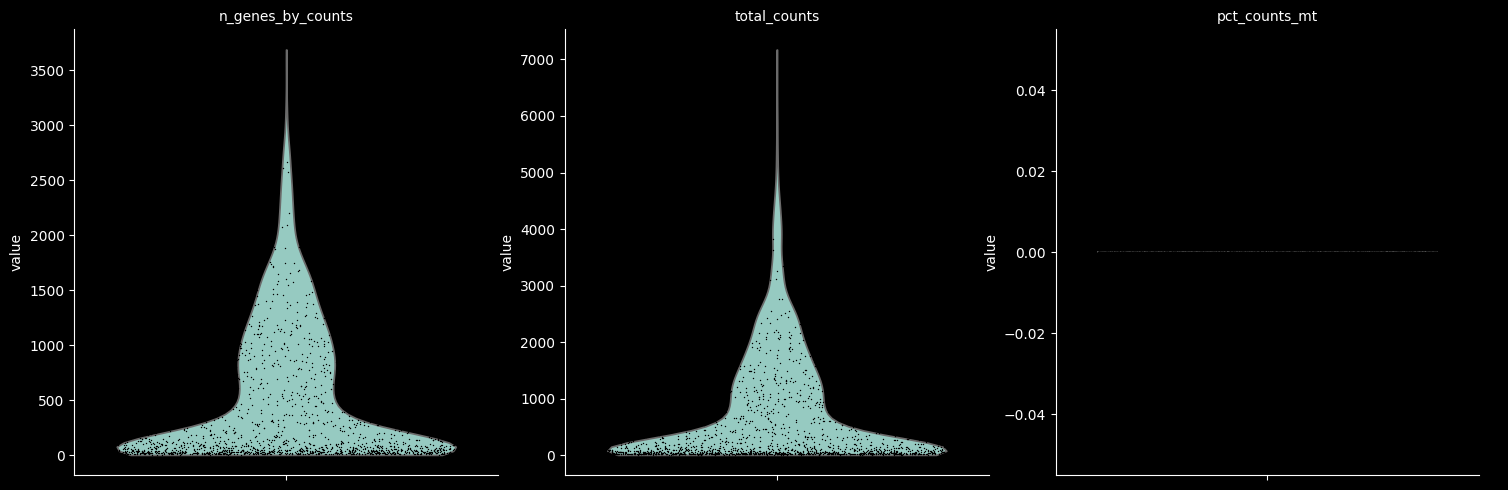

In [66]:
vis_adata.var["mt"] = vis_adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(vis_adata, qc_vars=["mt"], inplace=True)
sc.pl.violin(
    vis_adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)


In [67]:
sc.pp.filter_cells(vis_adata, min_genes=300)
sc.pp.normalize_total(vis_adata, inplace=True)
sc.pp.log1p(vis_adata)
sc.pp.highly_variable_genes(vis_adata, flavor="seurat", n_top_genes=2000, inplace=True)


In [79]:
marker_genes = ["Pou4f3", "Calb2", "Pvalb", "Smpx", "Mlf1", "Sox2"]  # 5 random Cochlear HCs P7 + Sox2

def normalize_marker_genes(gene_list, chosen_genes):
    """Convert to case-insensitive.  Also will not add chosen gene if not in gene list."""
    case_insensitive_genes = [g for cg in chosen_genes for g in gene_list if cg.lower() == g.lower()]
    return case_insensitive_genes

# Reset index to gene symbol to ensure gene names are the plot labels
#vis_adata.var.reset_index(inplace=True)
#vis_adata.var.set_index('gene_symbol', inplace=True)

# Deduplicate gene_symbols
vis_adata = vis_adata[:, vis_adata.var.index.duplicated() == False]

vis_adata.var_names_make_unique()
gene_symbols = vis_adata.var.index.tolist()
marker_genes = normalize_marker_genes(gene_symbols, marker_genes)

num_genes = len(marker_genes)
marker_genes

['Pou4f3', 'Calb2', 'Pvalb', 'Smpx', 'Mlf1', 'Sox2']

In [80]:
# get top 5 highly variable genes
highly_variable_genes = vis_adata.var[vis_adata.var.highly_variable].sort_values('dispersions_norm', ascending=False).index.tolist()
if len(highly_variable_genes) > 5:
    highly_variable_genes = highly_variable_genes[:5]
highly_variable_genes

['Ocm', 'S100a9', 'Scg2', 'S100a8', 'Kcne1']

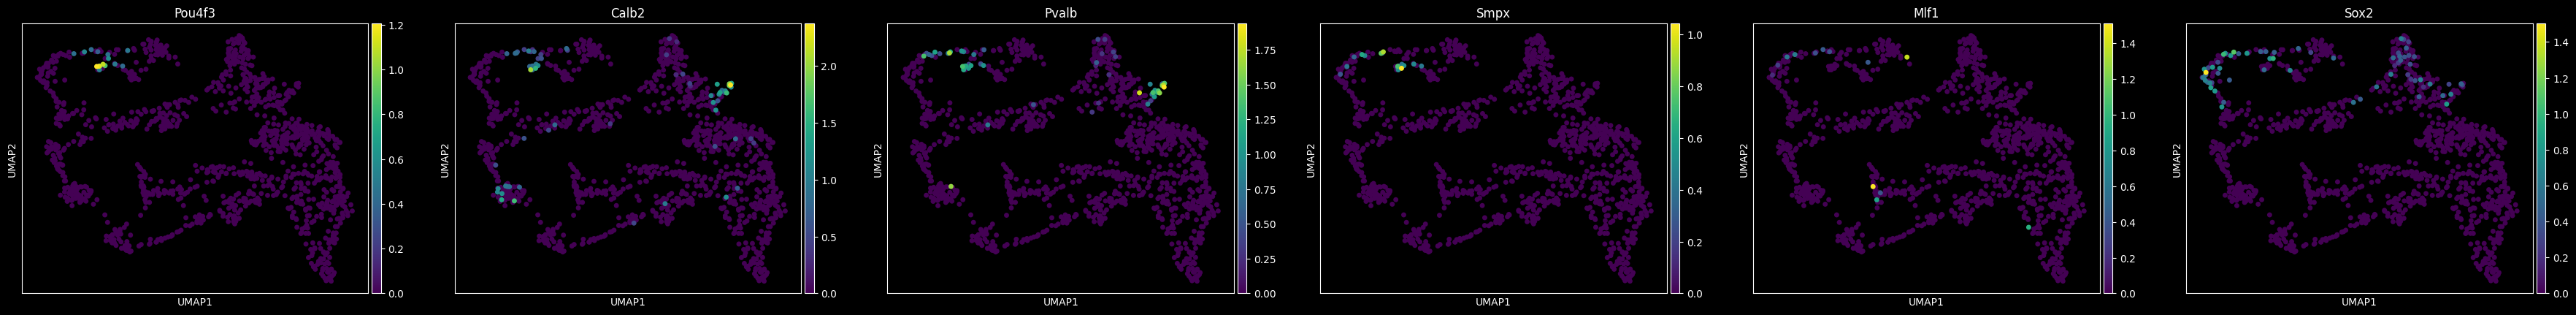

In [81]:
sc.pp.pca(vis_adata)
sc.pp.neighbors(vis_adata)
sc.tl.umap(vis_adata)
umap_ax = sc.pl.umap(vis_adata, color=marker_genes, ncols=num_genes, show=False)
# I keep adjusting until the resolution setting makes clusters roughly match the single-cell clusters
sc.tl.leiden(
    vis_adata, key_added="spatial_clusters", flavor="igraph", directed=False
)

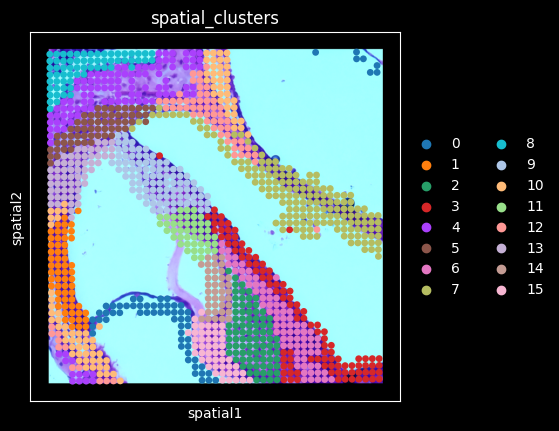

In [82]:
leiden_ax = sc.pl.spatial(vis_adata, img_key="hires", color="spatial_clusters", size=1, library_id="D1_hires_image", show=False)

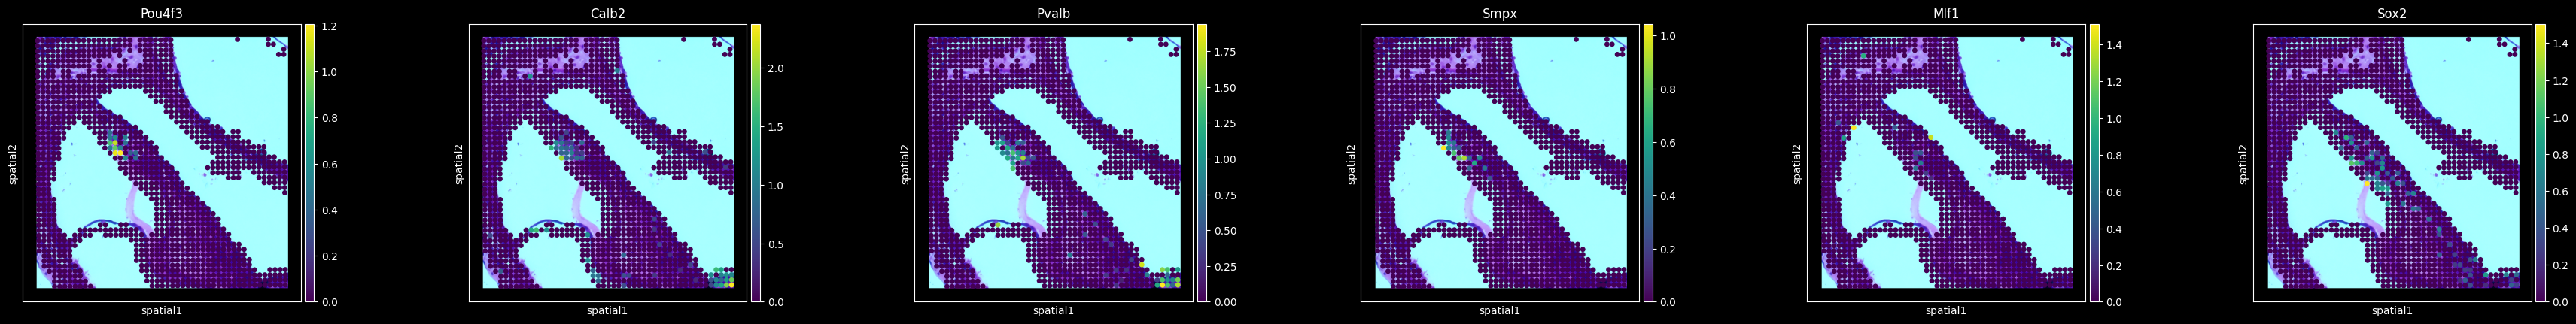

In [83]:
leiden2_ax = sc.pl.spatial(vis_adata, img_key="hires", color=marker_genes, size=1, library_id="D1_hires_image", ncols=num_genes, show=False)

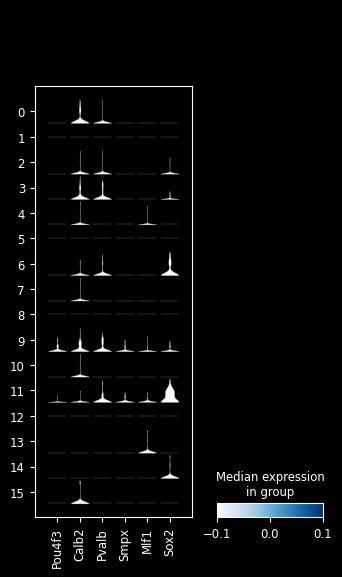

In [84]:
violin_ax = sc.pl.stacked_violin(vis_adata, marker_genes, groupby="spatial_clusters", use_raw=False, show=False)

[<Axes: title={'center': 'spatial_clusters'}, xlabel='spatial1', ylabel='spatial2'>]

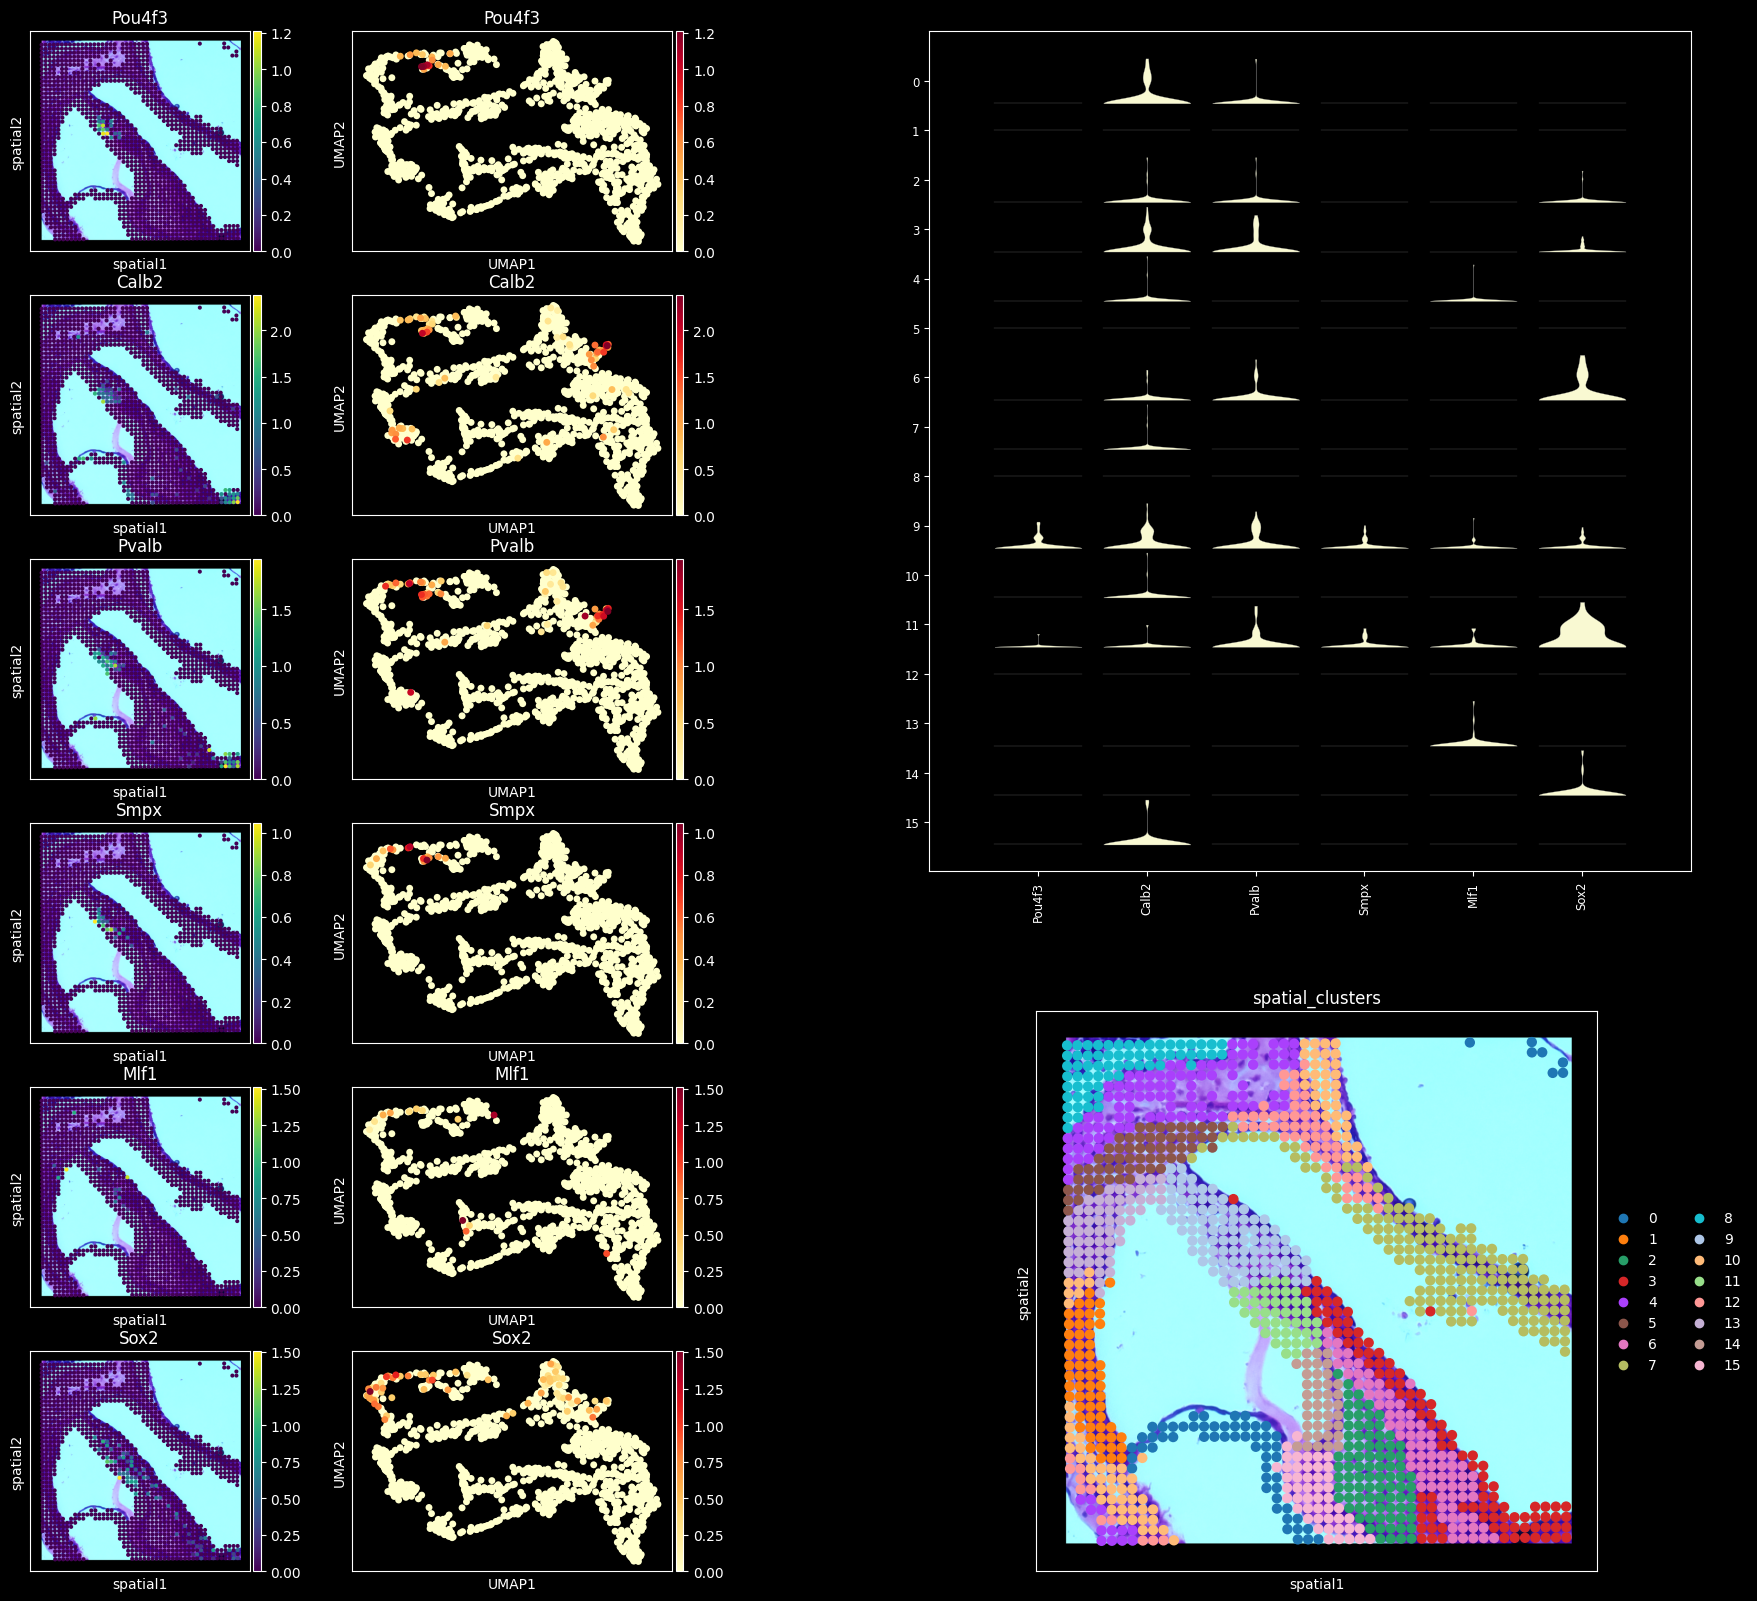

In [94]:

from matplotlib import pyplot as plt

# Split into 2 subfigures.  Left side will be "per-gene" plots, and right side will be "per-cluster" plots
fig = plt.figure(figsize=(20, 20))
subfigs = fig.subfigures(1, 2, wspace=None)

axs0 = subfigs[0].subplots(num_genes, 2)
ax_row = 0

for gene in marker_genes:
    sc.pl.spatial(vis_adata, img_key="hires", color=gene, size=1, library_id="D1_hires_image", ax=axs0[ax_row][0], show=False)
    sc.pl.umap(vis_adata, color=gene, ax=axs0[ax_row][1], color_map="YlOrRd", show=False)
    ax_row +=1

ax1, ax2 = subfigs[1].subplots(nrows=2, ncols=1, height_ratios=[0.6, 0.4])

violin_fig = sc.pl.stacked_violin(vis_adata, marker_genes, groupby="spatial_clusters", ax=ax1, cmap="YlOrRd", show=False, return_fig=True, figsize=(20, 20))
# Remove the existing legend and add a new vertically-oriented one
violin_fig.legend(show = False)
violin_fig.make_figure()
#plt.colorbar(violin_fig, cax=ax1.inset_axes([0.95, 0.1, 0.05, 0.8]), ax=ax1, orientation="vertical")

sc.pl.spatial(vis_adata, img_key="hires", color="spatial_clusters", size=1, library_id="D1_hires_image", ax=ax2, show=False)
